In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import numpy as np



In [3]:
#Load the data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers=0 #threads for data loading
batch_size=20
validation_size=0.2

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])
train_data = datasets.CIFAR10('data',train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data',train=False, download=True, transform=transform)

#separate train and validation sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size*num_train))
train_idx, validation_idx = indices[split:],indices[:split]


#define samplers for random batches
#https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a 
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

#data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = validation_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,num_workers=num_workers)

#specify the classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [10]:
#visualize a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img/2+0.5 #unnormalize
    plt.imshow(np.transpose(img,(1,2,0)))#convert from tensor image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


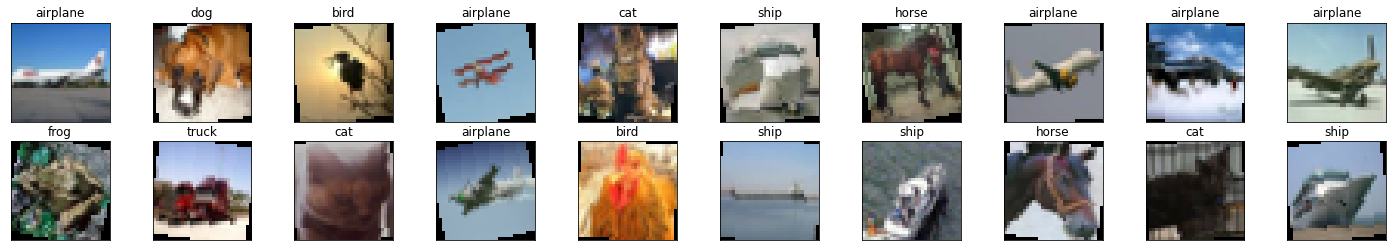

In [11]:
#get one batch of image and display
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

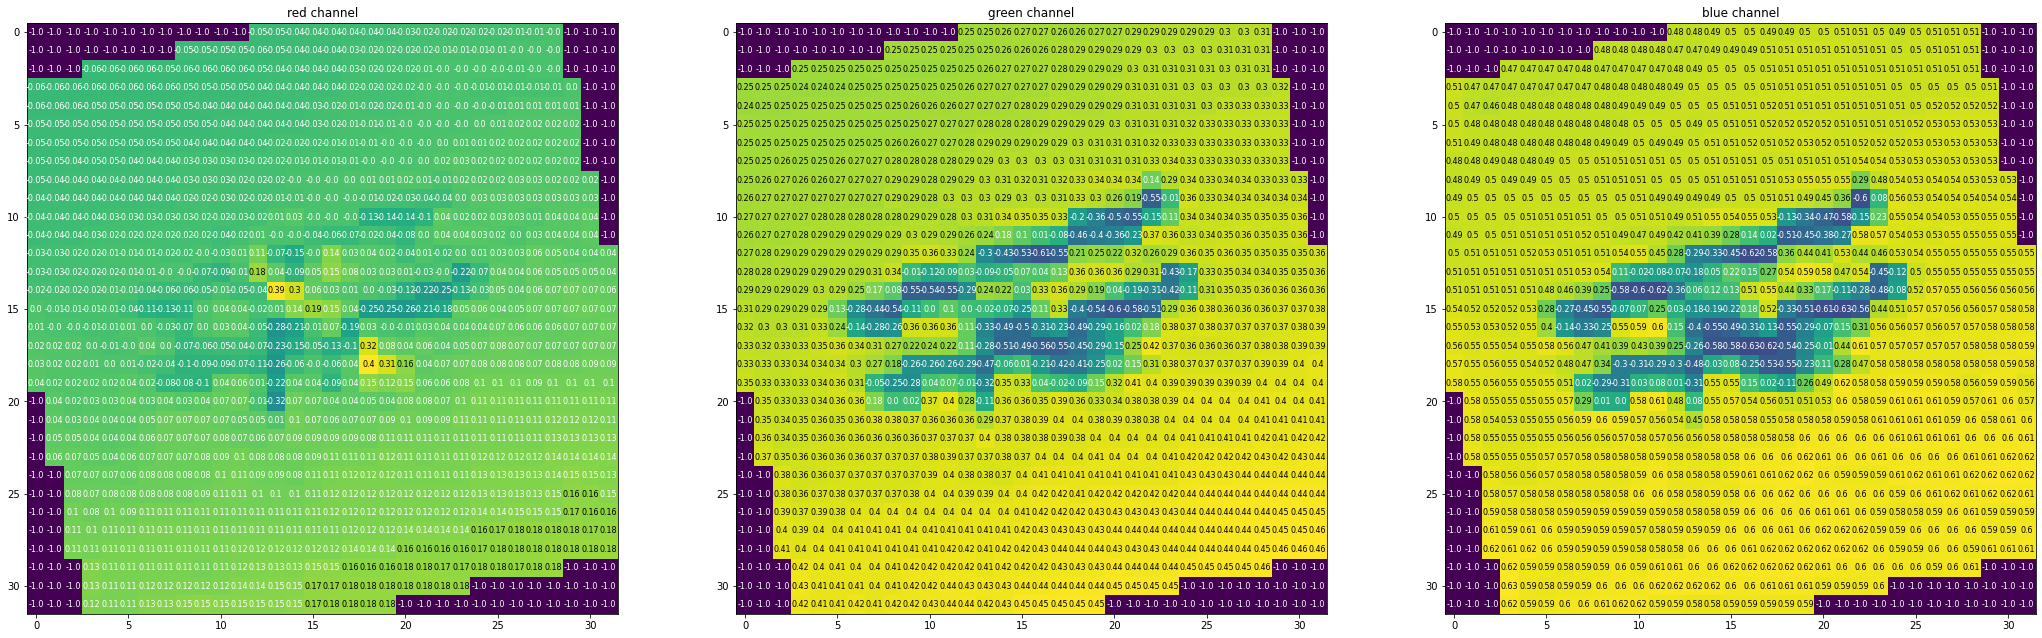

In [12]:
#images in detail
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img)
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [14]:
#nn architecture
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #image is originally 32*32*3
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        #after conv1 it will be 16-16*16
        self.conv2 = nn.Conv2d(16,24,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(24*8*8,500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,24*8*8)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=self.fc2(x)
        return x
    
model = Net()
print(model)




Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [48]:
# define the CNN architecture
class NetSoln(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [15]:
#move tensors to GPU if CUDA is available
#check for cuda
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("Cuda available")
else:
    print("Cuda not available")
if train_on_gpu:
    model.cuda()


Cuda available


In [16]:
#lost function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.003)


In [18]:
#train the network
n_epochs = 8
validation_loss_min = np.Inf # track change in validation loss

for epoch in range(1,n_epochs+1):
      # keep track of training and validation loss
    train_loss = 0.0
    validation_loss = 0.0
     ###################
    # train the model #
    ###################
    model.train() #set in train mode
    
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()#set in evaluation mode
    for data, target in validation_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        validation_loss+=loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    validation_loss = validation_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        validation_loss_min = validation_loss
    

Epoch: 1 	Training Loss: 1.775692 	Validation Loss: 0.409397
Validation loss decreased (inf --> 0.409397).  Saving model ...
Epoch: 2 	Training Loss: 1.540864 	Validation Loss: 0.359775
Validation loss decreased (0.409397 --> 0.359775).  Saving model ...
Epoch: 3 	Training Loss: 1.413688 	Validation Loss: 0.335197
Validation loss decreased (0.359775 --> 0.335197).  Saving model ...
Epoch: 4 	Training Loss: 1.333670 	Validation Loss: 0.315768
Validation loss decreased (0.335197 --> 0.315768).  Saving model ...
Epoch: 5 	Training Loss: 1.263829 	Validation Loss: 0.300733
Validation loss decreased (0.315768 --> 0.300733).  Saving model ...
Epoch: 6 	Training Loss: 1.207087 	Validation Loss: 0.286123
Validation loss decreased (0.300733 --> 0.286123).  Saving model ...
Epoch: 7 	Training Loss: 1.161772 	Validation Loss: 0.276905
Validation loss decreased (0.286123 --> 0.276905).  Saving model ...
Epoch: 8 	Training Loss: 1.135231 	Validation Loss: 0.271265
Validation loss decreased (0.27690

# Losses with plots

In [28]:
#train the network
n_epochs = 10
validation_loss_min = np.Inf # track change in validation loss
train_losses, validation_losses=[],[]
for epoch in range(1,n_epochs+1):
      # keep track of training and validation loss
    train_loss = 0.0
    validation_loss = 0.0
    
     ###################
    # train the model #
    ###################
    model.train() #set in train mode
    
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()#set in evaluation mode
    for data, target in validation_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        validation_loss+=loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    validation_loss = validation_loss/len(validation_loader.dataset)
    
    #add to list
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        validation_loss_min = validation_loss

Epoch: 1 	Training Loss: 1.046681 	Validation Loss: 0.250757
Validation loss decreased (inf --> 0.250757).  Saving model ...
Epoch: 2 	Training Loss: 1.027174 	Validation Loss: 0.245180
Validation loss decreased (0.250757 --> 0.245180).  Saving model ...
Epoch: 3 	Training Loss: 1.009410 	Validation Loss: 0.240318
Validation loss decreased (0.245180 --> 0.240318).  Saving model ...
Epoch: 4 	Training Loss: 0.995921 	Validation Loss: 0.237443
Validation loss decreased (0.240318 --> 0.237443).  Saving model ...
Epoch: 5 	Training Loss: 0.980707 	Validation Loss: 0.236913
Validation loss decreased (0.237443 --> 0.236913).  Saving model ...
Epoch: 6 	Training Loss: 0.967533 	Validation Loss: 0.230625
Validation loss decreased (0.236913 --> 0.230625).  Saving model ...
Epoch: 7 	Training Loss: 0.956639 	Validation Loss: 0.228467
Validation loss decreased (0.230625 --> 0.228467).  Saving model ...
Epoch: 8 	Training Loss: 0.941289 	Validation Loss: 0.225386
Validation loss decreased (0.22846

In [29]:
print(train_losses)
print(validation_losses)

[1.0466814399003983, 1.0271736416339874, 1.0094097060203553, 0.9959214189767838, 0.98070701546669, 0.9675332753896714, 0.9566391875743866, 0.9412890691995621, 0.9280822313070297, 0.9197214448332787]
[0.2507569781303406, 0.24517980167865752, 0.24031825513839722, 0.23744337859153747, 0.23691270468235015, 0.23062459890842438, 0.22846726610660553, 0.22538615276813506, 0.22175546655654907, 0.22104145669937134]


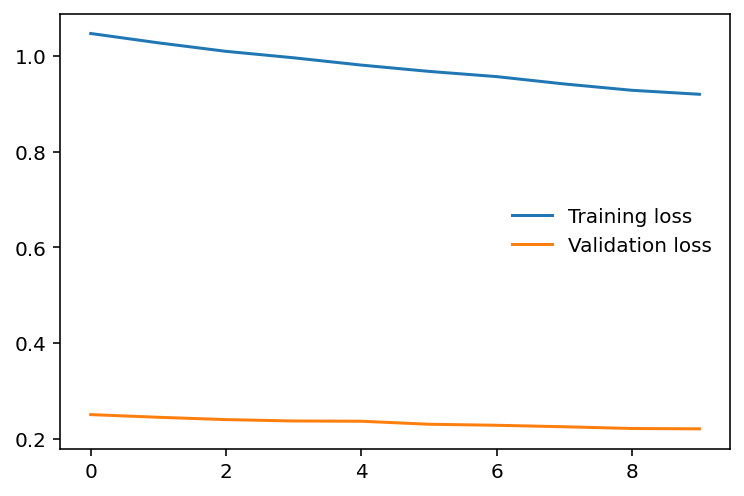

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [31]:
#get the model with lowest validation loss and test
model.load_state_dict(torch.load('model_cifar.pt'))
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 1.070901

Test Accuracy of airplane: 64% (3219/5000)
Test Accuracy of automobile: 77% (3871/5000)
Test Accuracy of  bird: 49% (2471/5000)
Test Accuracy of   cat: 44% (2236/5000)
Test Accuracy of  deer: 50% (2543/5000)
Test Accuracy of   dog: 48% (2445/5000)
Test Accuracy of  frog: 66% (3336/5000)
Test Accuracy of horse: 69% (3495/5000)
Test Accuracy of  ship: 82% (4144/5000)
Test Accuracy of truck: 70% (3546/5000)

Test Accuracy (Overall): 62% (31306/50000)


# Visualize sample test results

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


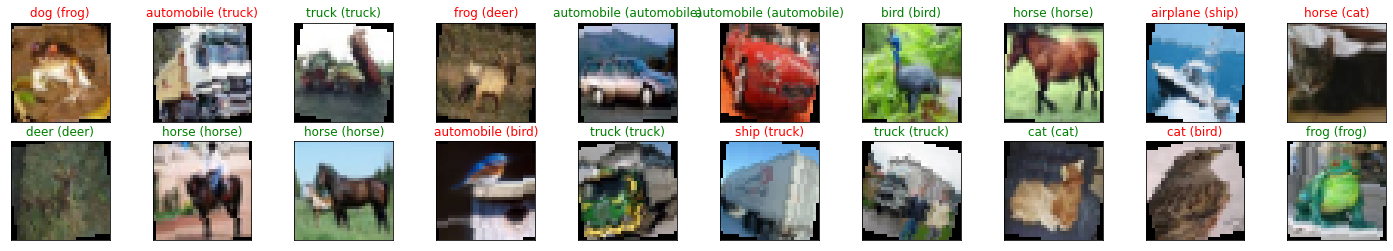

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))